# Airbnb Project

## Secition 1: Business Understanding

- Data: Airbnb-data of accomodations in Seattle, USA from 2016.
- The data for this project was taken from Kaeggle as a part of the Udacity nanodegree "Data Scientist".
- The goal is to provide somewhat of a data-driven guide for potential visitors, by trying to answer the following questions:

### Questions 1: What are the cheapest and most expensive neighborhoods in Seattle ?
### Questions 2: How do the occupancy rates inside the neighborhoods vary ?
### Questions 3: Can we predict prices of new Airbnb-listings, using location and property values ?

In [1118]:
#Import libraries:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns", None)

# Import files:
df_calendar = pd.read_csv("./data/archive/calendar.csv")
df_listings = pd.read_csv("./data/archive/listings.csv")
df_reviews = pd.read_csv("./data/archive/reviews.csv")

## Secition 2: Data Understanding
In this section, we are going to perform analysis of the data to understand what we are working with.

In [1121]:
# Let's check how many columns each csv-file hast
print("df_listings:" + str(df_listings.shape))
print("df_calendar:" + str(df_calendar.shape))
print("df_reviews:" + str(df_reviews.shape))
print("-------------")

df_listings:(3818, 92)
df_calendar:(1393570, 4)
df_reviews:(84849, 6)
-------------


In [1123]:
# Let's recheck if all NaN-values are excluded from the analysis:
calendar_nan_abs = df_calendar.isnull().sum()
calendar_nan_rel = calendar_nan_abs/df_calendar.shape[0]*100

calendar_nan_rel

listing_id     0.000000
date           0.000000
available      0.000000
price         32.938998
dtype: float64

In [1125]:
# The follwoing dataset provides a description of 3818 unique Airbnb-listings with a detailed description in 92 columns
print(df_listings["id"].nunique())
df_listings.head()

3818


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [1127]:
# The follwoing dataset provides a daily view of the status of the airbnbs (booked (=f) or available(=t)), 
# as well as the price if available.
# The column "listing-id" corresponds to the "id" column in df_listings.
print(df_calendar["listing_id"].nunique())
df_calendar.head()

3818


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [1129]:
# This dataset provides an overview of the comments, given by reviewers for airbnbs.
# It can be  connected to df_listings or df_calendar via the "listing_id"
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## Secition 3: Data Preparation

In order to be able to work with the availability and pricing data from df_calendar and the property details in df_listings, both dfs have to be combined. As mentioned before, the listing_id or just id can be used as a unique identifier for listings to perform the merging process. During that process, the amount of columns taken over from df_listings will be reduced to the "relevant" ones. Additional conversions and renamings will be performed as necessary.

In [1132]:
# Rename columns to match them (listing id) and to keep both pricing columns for now:
df_listings.rename(columns={"id": "listing_id"}, inplace=True)
df_listings.rename(columns={"price": "price_room"}, inplace=True)

# Create list of dfs to possibly integrate in future loops:
df_vec = [df_calendar, df_listings, df_reviews]

# Convert date columns to datetime-type:
df_calendar["date"] = pd.to_datetime(df_calendar["date"], format='%Y-%m-%d')
df_listings["host_since"] = pd.to_datetime(df_listings["host_since"], format='%Y-%m-%d')

# Converting the %-Values from String to Float:
df_listings["host_response_rate"] = df_listings["host_response_rate"].astype(str).str.replace('%', '').str.replace(',', '').astype(float)
df_listings["host_acceptance_rate"] = df_listings["host_acceptance_rate"].astype(str).str.replace('%', '').str.replace(',', '').astype(float)

# Converting the $-Values from String to Float:
df_calendar["price"] = df_calendar["price"].astype(str).str.replace("$", "").str.replace(",", "").astype(float)
dollars = ["price_room", "security_deposit", "cleaning_fee", "extra_people"]
for dollar in dollars:
    df_listings[dollar] = df_listings[dollar].astype(str).str.replace("$", "").str.replace(",", "").astype(float)

# Separation into relevant numeric and categoric data for further separate analysis (especially important for performing the conversion of categoric data in a later process):
df_cal_list_num = df_listings[["accommodates", "number_of_reviews", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "bathrooms", "bedrooms", "beds", "guests_included", "minimum_nights", "maximum_nights", "security_deposit", "cleaning_fee", "extra_people", "host_response_rate", "host_acceptance_rate"]]
df_cal_list_cat = df_listings[["listing_id", "cancellation_policy", "neighbourhood", "host_identity_verified", "host_has_profile_pic", "property_type", "room_type", "bed_type", "cancellation_policy", "require_guest_profile_picture", "require_guest_phone_verification", "instant_bookable", "host_is_superhost"]]

# Combination of num and cat variables to whole df_new of the calendar df:
df_new = pd.concat([df_cal_list_num, df_cal_list_cat], axis =1)

# Combination of "relevant" listing and calendar df:
df_new = pd.merge(df_new, df_calendar, on='listing_id', how='left')

df_new_num = df_new.select_dtypes(include=["int64", "float64"])
df_new_cat = df_new.select_dtypes(exclude=["int64", "float64"])

#Display the newly combined df_new:
df_new.head()

,accommodates,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,security_deposit,cleaning_fee,extra_people,host_response_rate,host_acceptance_rate,listing_id,cancellation_policy,neighbourhood,host_identity_verified,host_has_profile_pic,property_type,room_type,bed_type,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,instant_bookable,host_is_superhost,date,available,price
0,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,f,2016-01-04,t,85.0
1,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,f,2016-01-05,t,85.0
2,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,f,2016-01-06,f,NaN
3,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,f,2016-01-07,f,NaN
4,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,f,2016-01-08,f,NaN


In [1133]:
# Let's check how many different Airbnb-properties there are in each neighbourhood of Seattle:
unique_listing_counts = df_new.groupby("neighbourhood")["listing_id"].nunique().reset_index().sort_values(by="listing_id", ascending=False)
print(unique_listing_counts)

         neighbourhood  listing_id
10        Capitol Hill         351
3              Ballard         213
4             Belltown         204
44               Minor         192
59          Queen Anne         187
..                 ...         ...
54         Pike Market           2
67   South Beacon Hill           2
64             Roxhill           1
50  North College Park           1
17      Fairmount Park           1

[81 rows x 2 columns]


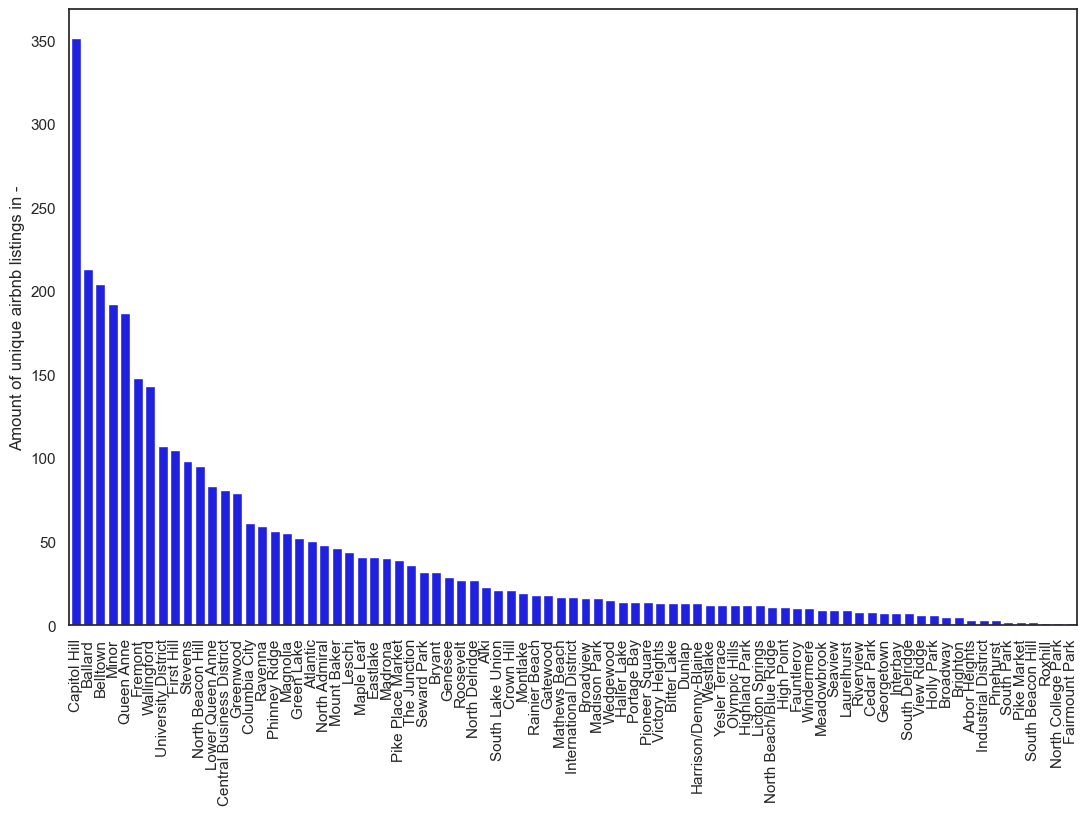

In [1136]:
# Plotting the amount of airbnbs in each neighbourhood:
sns.set_theme(style="white", rc={"figure.figsize":(13,8)})
fig, ax = plt.subplots()
neighbourhood_amount_airbnbs = sns.barplot(x="neighbourhood", y="listing_id", data=unique_listing_counts, color="blue", ax=ax)
ax.set(xlabel="", ylabel="Amount of unique airbnb listings in -")
ax.set_axisbelow(True)
ax.grid(False)
neighbourhood_amount_airbnbs.set_xticklabels(neighbourhood_amount_airbnbs.get_xticklabels(), rotation=90);

Looking at the figure above, the spread of airbnbs per neighbourhood is in the range of 1 to 350. Some neighborhoods that have a very small number of Airbnbs shall be excluded (the ones with less than 5 Airbnbs) as they would not be representative enough for a neighborhood.

In [1139]:
# Let's figure out how many neighbourhoods have less than 5 airbnb listings
excl_neighbourhoods = unique_listing_counts[unique_listing_counts["listing_id"] < 5]
excl_neighbourhoods = excl_neighbourhoods["neighbourhood"].tolist()

# Let's exclude those from further analysis
for neighbourhood in excl_neighbourhoods:
    df_new = df_new[df_new["neighbourhood"] != neighbourhood]

## Section 4: Modeling
This section will use a linear regression model to try to predict apartment prices based on various categoric and numeric values from the dfs.

<Axes: >

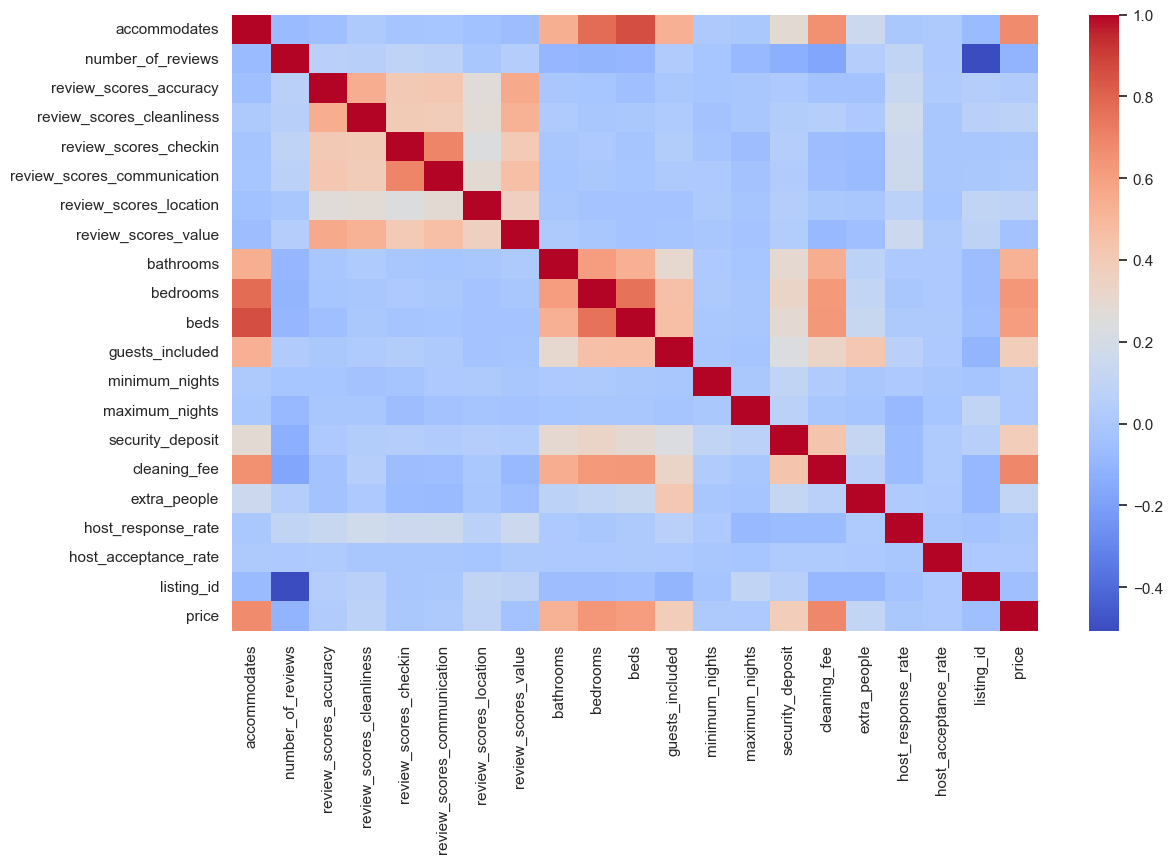

In [1142]:
# Let us look at the correlation matrix to see how dependant/independant values are from each other:
df_listings_corr_matrix = df_new_num.corr()
sns.heatmap(df_listings_corr_matrix, cmap='coolwarm', fmt='.2f')

Focusing on the price, we see that bathrooms, bedrooms, beds, amunt of people the airbnb accomodates, guests included, security deposit and cleaning fee have a goo correlation. Those will be used as numeric variables within the modeling step. 

In [1145]:
# In order to be able to use the categoric data, a creation of dummies will be performed in the following:
#Pull a list of the column names of the categorical variables
cat_cols_lst = df_cal_list_cat.columns

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

### Missing value analysis:

After performing the the missing-values analysis below, the following tasks will be performed:
- Security deposit and cleaning fee NaN values mean there is no security deposit, so it can be changed to 0
- The NaN-values in neighbourhood are going to be dropped as they cant be assigned to a "random" neighbourhood
- The NaN-price values can be dropped as they are the ones when the airbnb was not available (see initial calendar data)
- All review-related parameters, besides the review_scores_value will not be used in the model, which is why the rest will be ignored. Same goes for Host_ values

In [1148]:
# Let us check how many missing values df_new has absolutely and relative to the whole number of values in the column:
nan_abs = df_new.isnull().sum()
nan_rel = nan_abs/df_new.shape[0]*100
df_nan = pd.DataFrame({
    'Missing Values': nan_abs,
    'Ratio': nan_rel
})
# and let's display both columns:
df_nan

,Missing Values,Ratio
accommodates,0,0.000000
number_of_reviews,0,0.000000
review_scores_accuracy,238710,17.210526
review_scores_cleanliness,236885,17.078947
review_scores_checkin,238710,17.210526
review_scores_communication,236155,17.026316
review_scores_location,237615,17.131579
review_scores_value,237980,17.157895
bathrooms,5475,0.394737
bedrooms,2190,0.157895


In [1152]:
# Dropping the values according to the analysis above:
df_new["security_deposit"] = df_new["security_deposit"].fillna(0)
df_new["cleaning_fee"] = df_new["cleaning_fee"].fillna(0)

df_model = df_new.dropna(subset=["price", "neighbourhood"], axis=0)

# Calculate the mean of the "review_scores_value" column and fill NaN-values with mean:
mean_review_scores_value = df_model["review_scores_value"].mean()
df_model.loc[:, "review_scores_value"] = df_model["review_scores_value"].fillna(mean_review_scores_value)

df_model = df_new.dropna(subset=["price", "neighbourhood"], axis=0)
df_model = df_model.drop(["review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "minimum_nights", "maximum_nights", "host_response_rate", "host_acceptance_rate", "host_is_superhost", "date", "available", "listing_id"], axis=1)
df_model = df_model.dropna()

In [1155]:
# Let's recheck if all NaN-values are excluded from the analysis:
nan_abs = df_model.isnull().sum()
nan_rel = nan_abs/df_model.shape[0]*100

df_nan = pd.DataFrame({
    'Missing Values': nan_abs,
    'Ratio': nan_rel
})

df_nan

,Missing Values,Ratio
accommodates,0,0.0
number_of_reviews,0,0.0
review_scores_value,0,0.0
bathrooms,0,0.0
bedrooms,0,0.0
beds,0,0.0
guests_included,0,0.0
security_deposit,0,0.0
cleaning_fee,0,0.0
extra_people,0,0.0


In [1157]:
# Create dummies for categoric variables using the prior created function:
df_model = create_dummy_df(df_model, df_cal_list_cat, dummy_na=False)

# Fill the mean (not applied, as dropping NaN-values makes more sense for the chosen data)
# fill_mean = lambda col: col.fillna(col.mean())
# df_new = df_new.apply(fill_mean, axis=0)

# Split into explanatory and response variables
y = df_model.pop("price")
X = df_model

# Split X into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=1)

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

# Predict the test data#
y_test_preds = lm_model.predict(X_test)
# Additionally perform prediction on training data for latter comparison (see Question 3, figures)
y_train_preds = lm_model.predict(X_train)

## Section 5: Evaluate the results

### Questions 1: What are the cheapest and most expensive neighborhoods in Seattle ?
Now Let's look at average prices inside the neighbourhoods:

                neighbourhood       price
52                Portage Bay  250.885285
70                 Windermere  227.516092
0                        Alki  226.410733
69                   Westlake  225.336634
11  Central Business District  213.575584
..                        ...         ...
54              Rainier Beach   80.120382
28                 Holly Park   78.184594
21                 Georgetown   78.025107
56                  Riverview   77.346276
48              Olympic Hills   66.256790

[72 rows x 2 columns]
129.4619950782135


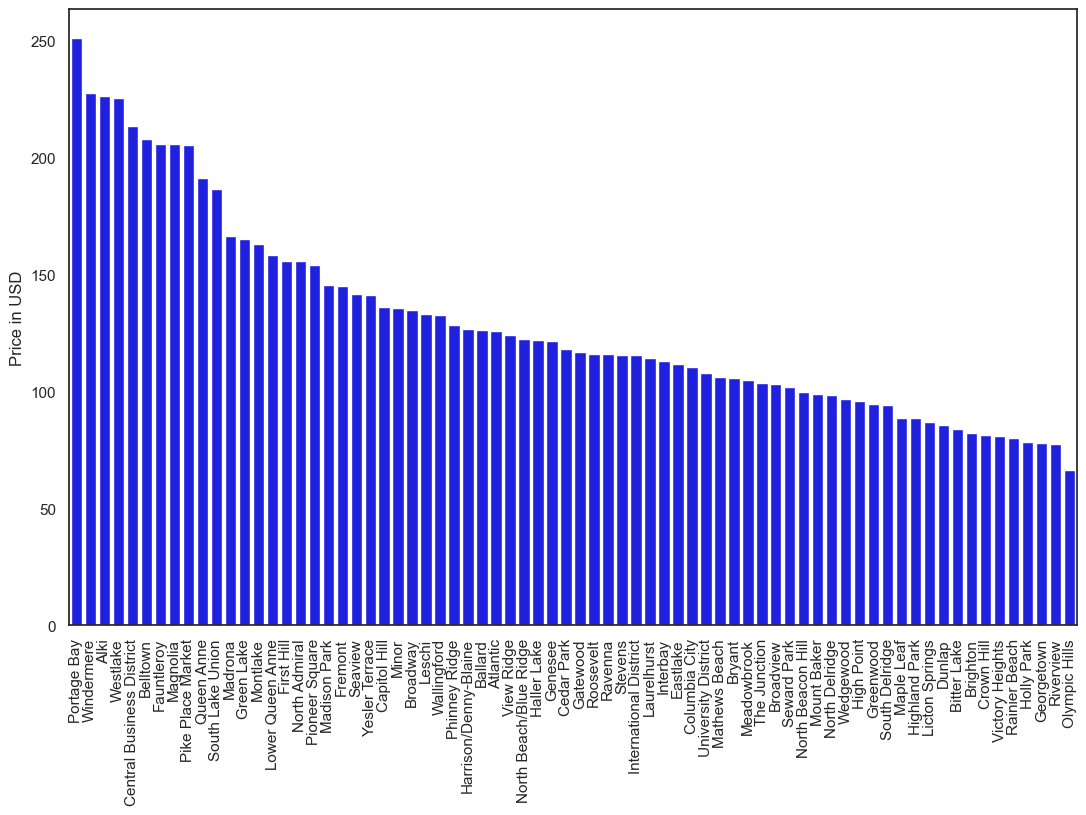

In [1161]:
df_neighbourhood_prices = df_new[["neighbourhood", "price"]]
df_neighbourhood_prices = df_neighbourhood_prices.groupby("neighbourhood").mean().reset_index()
df_neighbourhood_prices = df_neighbourhood_prices.sort_values(by="price", ascending=False)

sns.set_theme(style="white", rc={"figure.figsize":(13,8)})
fig, ax = plt.subplots()
neighbourhood_prices = sns.barplot(x="neighbourhood", y="price", data=df_neighbourhood_prices, color="blue", ax=ax)
ax.set(xlabel="", ylabel="Price in USD")
ax.set_axisbelow(True)
ax.grid(False)
neighbourhood_prices.set_xticklabels(neighbourhood_prices.get_xticklabels(), rotation=90);

# Print to get explicit values for max/min and mean:
print(df_neighbourhood_prices)
print(df_neighbourhood_prices["price"].mean())

Room prices of airbnbs in Seattle can strongly differ depending on the neighborhood one wants to stay at as the above figure shows. The yearly-average room prices can vary from as low as 66 USD a night for Olympic Hills up to 250 USD for Portage Bay with a mean of 129 USD for all Seattle neighborhoods.

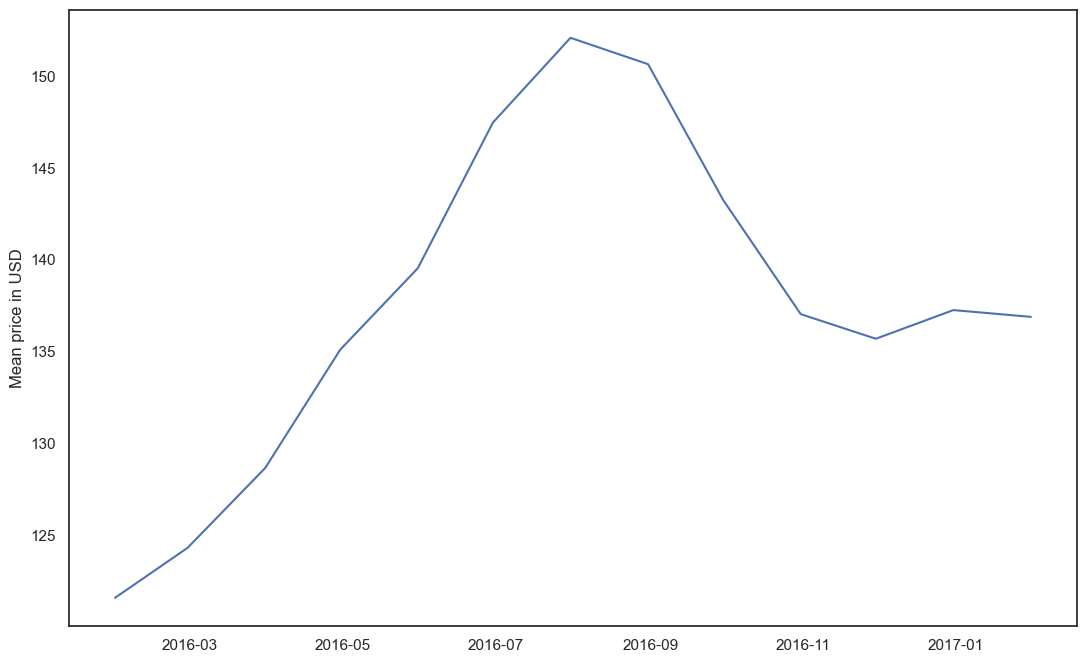

                 price
date                  
2016-01-31  121.568409
2016-02-29  124.293927
2016-03-31  128.644488
2016-04-30  135.097005
2016-05-31  139.538183
2016-06-30  147.473137
2016-07-31  152.094150
2016-08-31  150.656594
2016-09-30  143.255949
2016-10-31  137.031939
2016-11-30  135.688738
2016-12-31  137.251835
2017-01-31  136.882590


In [1163]:
# Let us plot the monthly averaged mean prices of all airbnbs in seattle and look how they change on a month-to-month basis:
df_monthly_mean_price = df_calendar_t[["price","date"]].resample("M", on="date").mean()

plt.plot(df_monthly_mean_price.index, df_monthly_mean_price["price"])
plt.ylabel("Mean Price")
plt.ylabel("Mean price in USD")

plt.show()

print(df_monthly_mean_price)

The mean price over all airbnbs in Seattle varies throughout the year from 121 USD at the beginning of the year up to 152 USD in the summer months.'

Summary: The prices of airbnbs vary between neighbourhoods from 66 USD to 251 USD, as well as throughout the year from 121 USD at the beginnng of the year to 137 USD at the end. The final price is influenced by a complex set of parameters and will be modeled in a later section of the analysis.

### Questions 2: How do the occupancy rates inside the neighborhoods vary ?
Let's look at how the occupancy values of airbnbs behave in Seattles neighbourhoods:

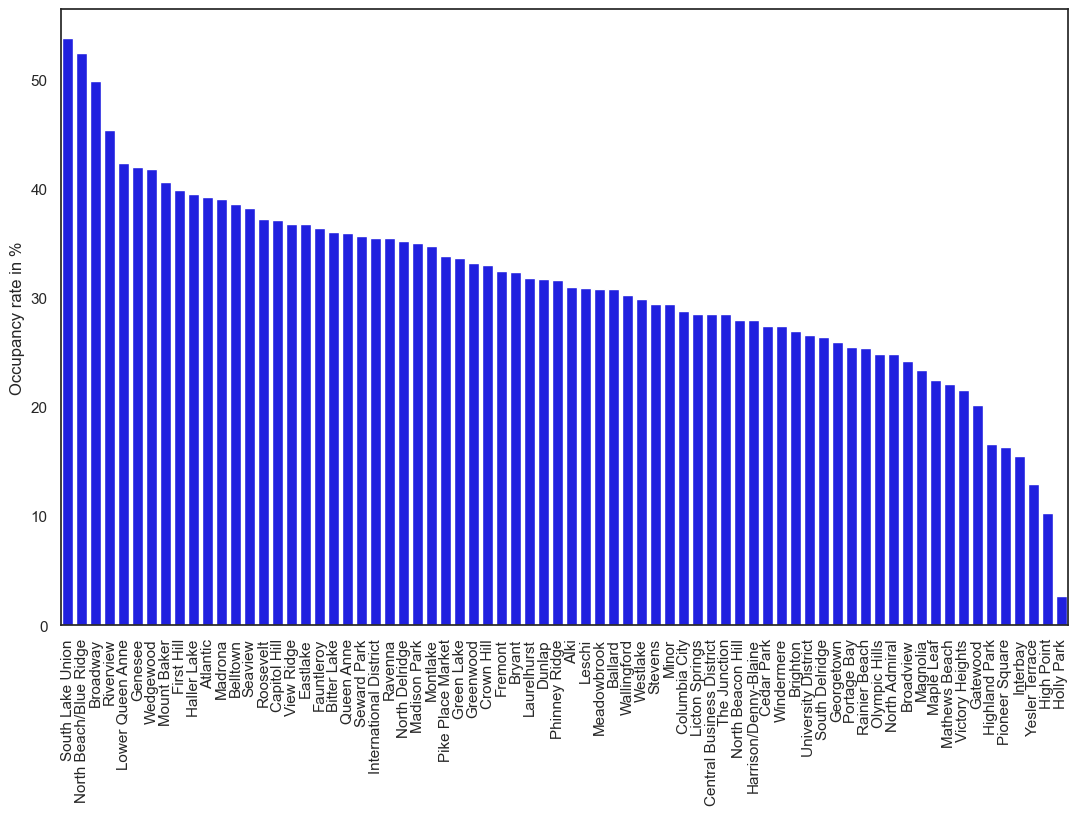

             neighbourhood  available
61        South Lake Union  53.804007
45  North Beach/Blue Ridge  52.448886
7                 Broadway  49.854617
56               Riverview  45.364197
34        Lower Queen Anne  42.419893
..                     ...        ...
51          Pioneer Square  16.329335
29                Interbay  15.530030
71          Yesler Terrace  12.895579
26              High Point  10.315572
28              Holly Park   2.673578

[72 rows x 2 columns]
31.21537350340423


In [1167]:
# Calculate the mean occupancy rate per neighbourhood
df_occup_ratio = (
    df_new
    .groupby(["neighbourhood", pd.Grouper(key="date", freq="M")])["available"]
    .apply(lambda x: (1 - (x == "t").sum() / len(x)) * 100)
    .reset_index()
)

# Group and sort the values
df_neighbourhood_occup = df_occup_ratio.groupby("neighbourhood")["available"].mean().reset_index()
df_neighbourhood_occup = df_neighbourhood_occup.sort_values(by="available", ascending=False)

# Create the plot
sns.set_theme(style="white", rc={"figure.figsize":(13,8)})
fig, ax = plt.subplots()
neighbourhood_occup = sns.barplot(x="neighbourhood", y="available", data=df_neighbourhood_occup, color="blue", ax=ax)
ax.set_axisbelow(True)
ax.grid(False)
neighbourhood_occup.set_xticklabels(neighbourhood_occup.get_xticklabels(), rotation=90)
ax.set(xlabel="", ylabel="Occupancy rate in %")
plt.show()

print(df_neighbourhood_occup)
print(df_neighbourhood_occup["available"].mean())

The occupancy varies from 2.6% in Holly Park to 54% in South Lake Union with an average value of 31% over all of Seattle’s neighborhood’s. Just like the price, the ccupancy rates are influenced by multiple variables. I’m refraining from diving deeper into this atm., but the occupation rate would also be a great value which one could try to predict, using machine learning.

Let us figure out whether the occupancy-rate varies over time throughout the year looking at the mean of all airbnbs in Seattle

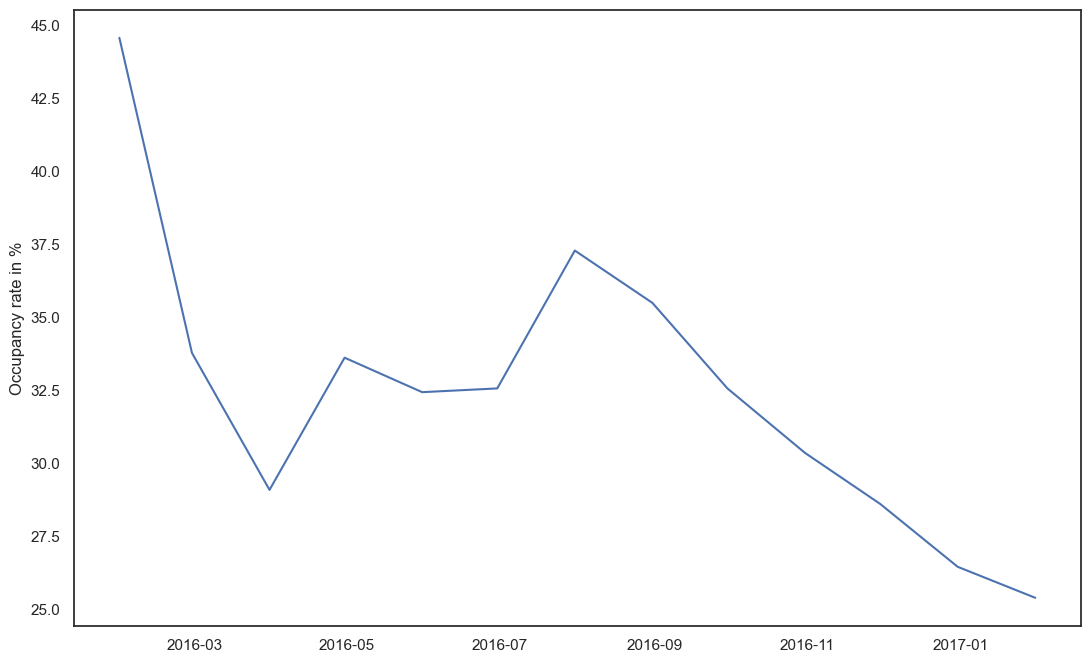

date
2016-01-31    44.586732
2016-02-29    33.779195
2016-03-31    29.081262
2016-04-30    33.615331
2016-05-31    32.432958
2016-06-30    32.561551
2016-07-31    37.290255
2016-08-31    35.494855
2016-09-30    32.559804
2016-10-31    30.348603
2016-11-30    28.601362
2016-12-31    26.442657
2017-01-31    25.379780
Freq: M, Name: available, dtype: float64


In [1192]:
df_monthly_occup_ratio = df_calendar.resample("M", on="date")["available"].apply(lambda x: (1 - (x == "t").sum() / len(x)) * 100)

plt.plot(df_monthly_occup_ratio.index, df_monthly_occup_ratio.values)
plt.ylabel("Occupancy rate in %")

plt.show()

print(df_monthly_occup_ratio)

The mean occupancy rate shows a falling trend over the year from initially 45% to 25%.

Next, let's look into the different neighbourhoods to see whether the mean trend represents the the trend within each neighbourhood

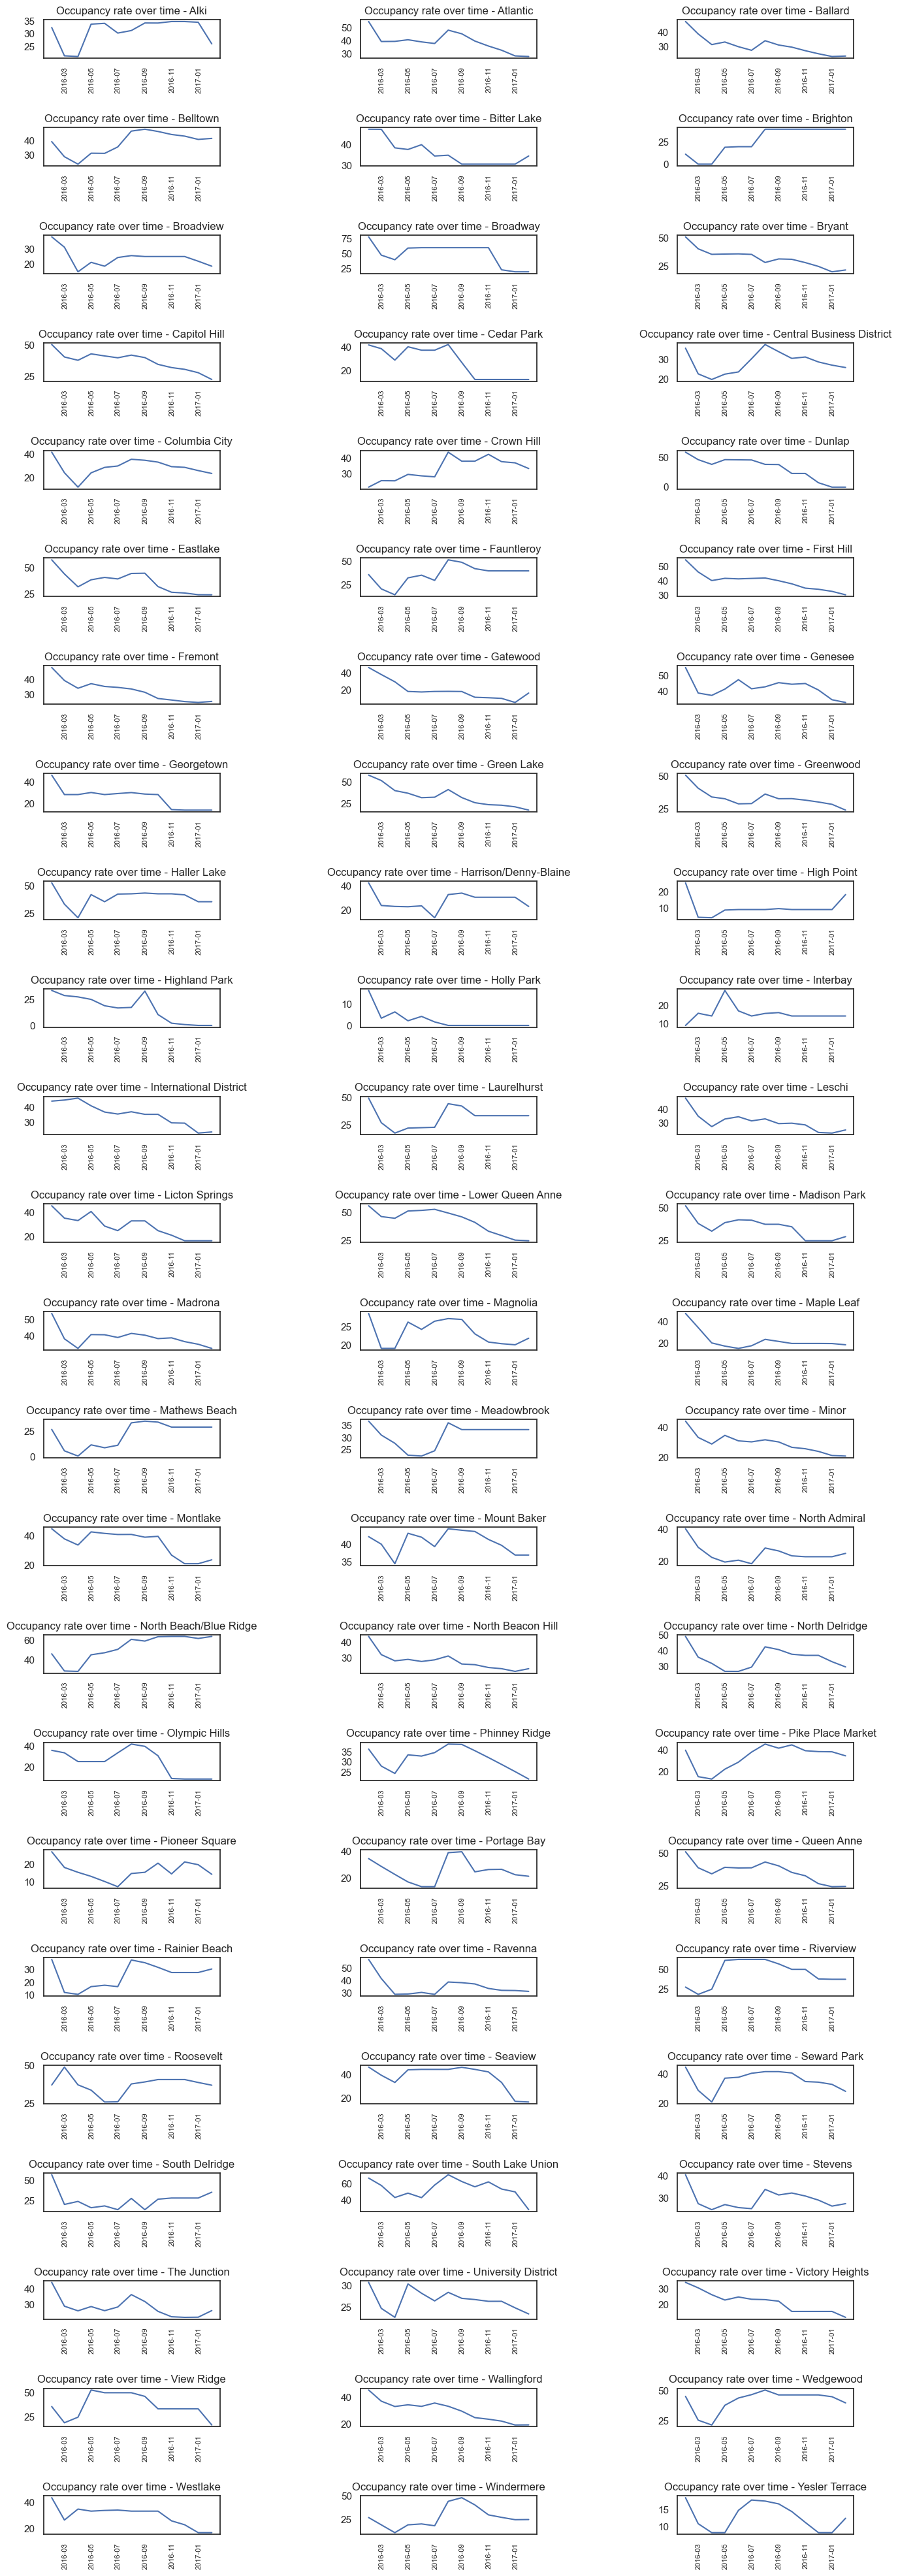

In [1174]:
# Get the unique neighbourhoods:
neighbourhoods = df_occup_ratio["neighbourhood"].unique()

# Calculate the number of rows and columns for the grid layout:
num_plots = len(neighbourhoods)
num_cols = 3
num_rows = math.ceil(num_plots / num_cols)

# Create a figure with grid layout:
fig = plt.figure(figsize=(16, 50))
gs = fig.add_gridspec(num_rows, num_cols, wspace=0.8, hspace=1.8)

# Loop through the neighbourhoods and plot the occupancy rate:
for i, neighbourhood in enumerate(neighbourhoods):
    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    df_occup = df_occup_ratio[df_occup_ratio["neighbourhood"] == neighbourhood]
    ax.plot(df_occup["date"], df_occup["available"])
    ax.set_title(f"Occupancy rate over time - {neighbourhood}")
    ax.tick_params(axis="x", which="major", rotation=90, labelsize=8)
plt.show()

Most neighbourhoods in Seattle follow the falling trend shown in the previous figure. This could be due to an absolute lower influx of tourists.£

Summary: The occupancy rate of airbnbs varies between neighbourhoods from 2.6% to 54%, as well as throughout the year from 45% at the beginnng of the year to 25% at the end. Most neighbourhoods roughly follow the falling trend of occupancy which might be due to macroeconomic effects. The data can't give enough info to figure out the reason for this effect.

### Questions 3: Can we predict prices of new Airbnb-listings, using location and property values ?

Let us evaluate how "accurate" the model from Section 4 can predict prices of new listings by using the r-squared score for the model as following:

In [1179]:
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model was 0.6382721787747418 on 210611 values.'

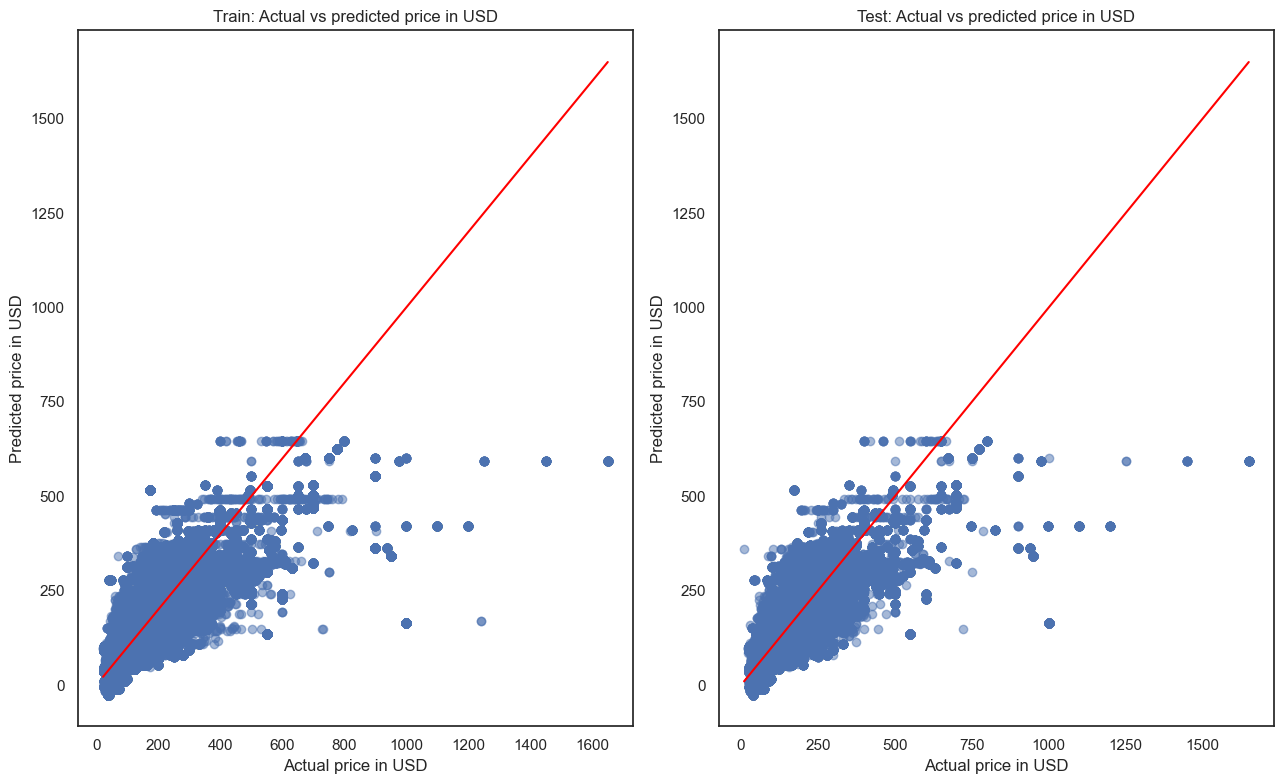

In [1181]:
# Plotting the results
plt.figure(figsize=(13, 8))

# Plot train results
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_preds, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '-', color='red')
plt.xlabel("Actual price in USD")
plt.ylabel("Predicted price in USD")
plt.title("Train: Actual vs predicted price in USD")

# Plot test results
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', color='red')
plt.xlabel("Actual price in USD")
plt.ylabel("Predicted price in USD")
plt.title("Test: Actual vs predicted price in USD")

plt.tight_layout()
plt.show()

Summary: With a r-squared score of 0.638, using a linear regression approach, a model was created that is not sufficiently accurate to predict prices of new airbnb-listings in Seattle. There is still room for improvement, when it comes to accuracy. As this is the first project, I will refrain from trying to optimize the model by using more elaborate models.